In [18]:
import sqlite3
import os
import pandas as pd
from sqlalchemy import create_engine
import datetime as dt
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [5]:

engine = create_engine('sqlite:///train.db')

# load CSV in chunks (avoid memory issues)
chunksize = 50000   # play around with 50k–100k depending on RAM
i = 0

for chunk in pd.read_csv("final_features.csv", chunksize=chunksize):
    chunk.to_sql(
    name="data",
    con=engine,
    if_exists="append" if i > 0 else "replace",
    index=False,
    chunksize=1000,   # reduce so that cols * rows < 32767
     
    )

    i += 1
    print(f"Inserted {i*chunksize} rows")


Inserted 50000 rows
Inserted 100000 rows
Inserted 150000 rows
Inserted 200000 rows
Inserted 250000 rows
Inserted 300000 rows
Inserted 350000 rows
Inserted 400000 rows
Inserted 450000 rows


In [6]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)

    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables = table_names.fetchall()
    if len(tables) == 0:
        print("No tables found in the database.")
    else:
        print(tables[0][0])
    return len(tables)

In [7]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [8]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)

        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [9]:
# remove the first row
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [10]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.999950,0.222220,0.333322,0.111110,0.599988,0.124999,0.0,0.0,19.0,14.5,...,0.956736,10.747933,6.440357,-3.480065,2.639530,3.556714,-4.802439,-0.686556,2.268094,6.028256
2,0.749981,0.599988,0.000000,0.000000,0.428565,0.374995,1.0,0.0,1.0,7.5,...,4.558088,4.970702,7.202400,-8.612651,5.620186,-6.103358,0.046644,6.589027,-3.269796,-2.372748
3,0.000000,0.000000,0.285710,0.249997,0.181817,0.105263,0.0,0.0,8.0,15.0,...,4.684145,-2.841745,2.030680,2.082265,6.906446,-0.076473,-10.195292,16.054584,4.445719,-0.307180
4,0.599988,0.499992,0.499988,0.399992,0.499995,0.499995,0.0,0.0,0.0,10.0,...,10.623747,21.813682,12.209059,-12.876388,5.630571,-4.373722,-11.028535,6.271225,22.940687,-1.295273
5,0.333328,0.249997,0.000000,0.000000,0.181817,0.166665,0.0,0.0,1.0,11.5,...,-6.179610,7.189821,6.935977,-1.452114,7.229710,7.122127,-7.914030,-11.723856,12.572501,-2.931032


In [11]:
pd.set_option('display.max_columns', None)

# Show ALL rows if you want (but careful with big data)
# pd.set_option('display.max_rows', None)

# Show full column width without cutting off text
pd.set_option('display.max_colwidth', None)

# Now display the first 5 rows fully
print(data.head(5))

    cwc_min   cwc_max   csc_min   csc_max   ctc_min   ctc_max  last_word_eq  \
1  0.999950  0.222220  0.333322  0.111110  0.599988  0.124999           0.0   
2  0.749981  0.599988  0.000000  0.000000  0.428565  0.374995           1.0   
3  0.000000  0.000000  0.285710  0.249997  0.181817  0.105263           0.0   
4  0.599988  0.499992  0.499988  0.399992  0.499995  0.499995           0.0   
5  0.333328  0.249997  0.000000  0.000000  0.181817  0.166665           0.0   

   first_word_eq  abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  \
1            0.0          19.0      14.5               71                24   
2            0.0           1.0       7.5               65                70   
3            0.0           8.0      15.0               42                39   
4            0.0           0.0      10.0               75                73   
5            0.0           1.0      11.5               59                50   

   fuzz_ratio  fuzz_partial_ratio  longest_substr_

In [12]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
100_x
101_x
102_x
103_x
104_x
105_x
106_x
107_x
108_x
109_x
110_x
111_x
112_x
113_x
114_x
115_x
116_x
117_x
118_x
119_x
120_x
121_x
122_x
123_x
124_x
125_x
126_x
127_x
128_x
129_x
130_x
131_x
132_x
133_x
134_x
135_x
136

In [13]:
y_true = list(map(int, y_true.values))

In [14]:
# stratify is very imp argument.
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [13]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 794)
Number of data points in test data : (30000, 794)


In [18]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6316 Class 1:  0.3684
---------- Distribution of output variable in train data ----------
Class 0:  0.6316 Class 1:  0.3684


In [17]:
"""It guesses randomly for every question. For each question in your test data, the code flips a coin (metaphorically) to decide if it's a duplicate or not. It assigns a random probability to each outcome.

It checks how bad the random guess was. It then measures how wrong these random guesses were using log_loss and a confusion matrix.

The main idea is to show that any real machine learning model you train should be able to perform much better than this baseline of just randomly guessing."""

"It guesses randomly for every question. For each question in your test data, the code flips a coin (metaphorically) to decide if it's a duplicate or not. It assigns a random probability to each outcome.\n\nIt checks how bad the random guess was. It then measures how wrong these random guesses were using log_loss and a confusion matrix.\n\nThe main idea is to show that any real machine learning model you train should be able to perform much better than this baseline of just randomly guessing."

In [15]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j

    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column

    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1

    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]]
    plt.figure(figsize=(20,4))

    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()

Log loss on Test Data using Random Model: 0.8922356907814792
Accuracy on Test Data using Random Model: 0.49393333333333334


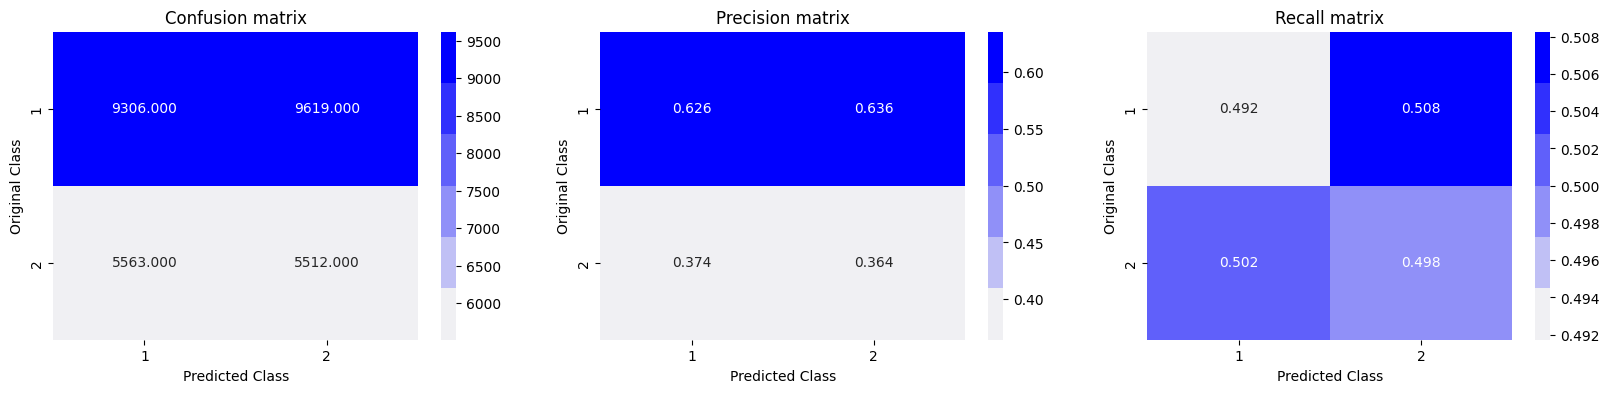

In [18]:
y_test_array = np.array(y_test)

# Random predictions
predicted_y = np.zeros((len(y_test_array), 2))
for i in range(len(y_test_array)):
    rand_probs = np.random.rand(1, 2)
    predicted_y[i] = (rand_probs / rand_probs.sum())[0]

# Log loss (works with probabilities)
print("Log loss on Test Data using Random Model:", log_loss(y_test_array, predicted_y))

# Convert probabilities to class labels
predicted_classes = np.argmax(predicted_y, axis=1)

# Accuracy
print("Accuracy on Test Data using Random Model:", accuracy_score(y_test_array, predicted_classes))

# Confusion matrix plot
plot_confusion_matrix(y_test_array, predicted_classes)

In [4]:
def test_random_model_on_questions(q1, q2):
    
    rand_probs = np.random.rand(1, 2)
    rand_probs = rand_probs / rand_probs.sum()
    predicted_class = np.argmax(rand_probs)
    print(f"Question 1: {q1}")
    print(f"Question 2: {q2}")
    print(f"Random Model Prediction: {'Duplicate' if predicted_class == 1 else 'Not Duplicate'}")
    print(f"Probabilities: Not Duplicate={rand_probs[0][0]:.3f}, Duplicate={rand_probs[0][1]:.3f}")

# Example usage:
test_random_model_on_questions("What is the capital of France?", "Which city is the capital of France?")

# ...existing code for random model evaluation...
y_test_array = np.array(y_test)

# Random predictions
predicted_y = np.zeros((len(y_test_array), 2))
for i in range(len(y_test_array)):
    rand_probs = np.random.rand(1, 2)
    predicted_y[i] = (rand_probs / rand_probs.sum())[0]

# Log loss (works with probabilities)
print("Log loss on Test Data using Random Model:", log_loss(y_test_array, predicted_y))

# Convert probabilities to class labels
predicted_classes = np.argmax(predicted_y, axis=1)

# Accuracy
print("Accuracy on Test Data using Random Model:", accuracy_score(y_test_array, predicted_classes))

# Confusion matrix plot
plot_confusion_matrix(y_test_array, predicted_classes)

Question 1: What is the capital of France?
Question 2: Which city is the capital of France?
Random Model Prediction: Not Duplicate
Probabilities: Not Duplicate=0.682, Duplicate=0.318


NameError: name 'y_test' is not defined

c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


For values of alpha =  1e-05 The log loss is: 0.5107725351229678


c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


For values of alpha =  0.0001 The log loss is: 0.44249779188993227


c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


For values of alpha =  0.001 The log loss is: 0.4452812670684912


c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


For values of alpha =  0.01 The log loss is: 0.44557168699727356


c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


For values of alpha =  0.1 The log loss is: 0.4472478594228647


c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


For values of alpha =  1 The log loss is: 0.4726573369257598
For values of alpha =  10 The log loss is: 0.5152035336150297


c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


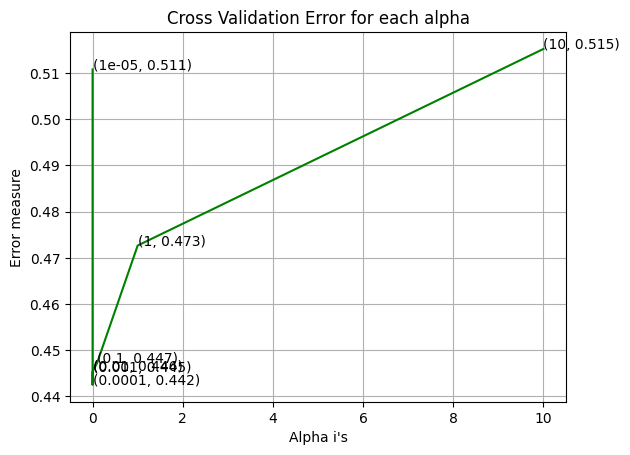

c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


For values of best alpha =  0.0001 The train log loss is: 0.4334787920871114


c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


For values of best alpha =  0.0001 The test log loss is: 0.44249779188993227
Total number of data points : 30000


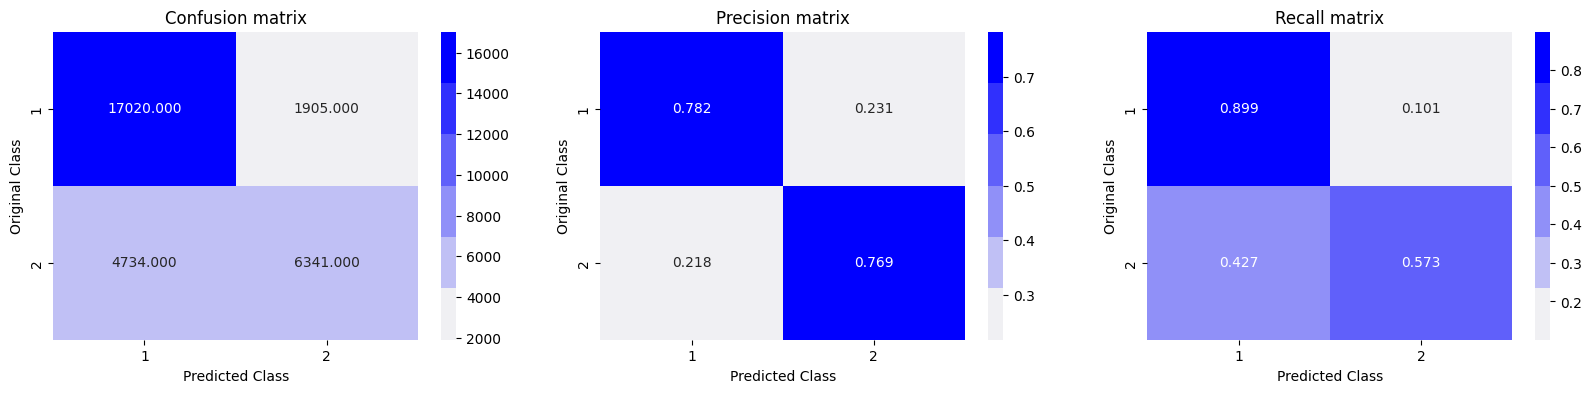

In [22]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None,
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5,
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link:
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan]
  warnings.warn(


Best alpha from GridSearchCV: 1e-05
Best (negative) log loss: nan


c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


Train log loss: 0.659008881653579


c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\Aditya\AppData\Local\Temp\ipykernel_7256\2390801568.py:22: RuntimeWarning: invalid value encountered in divide
  B =(C/C.sum(axis=0))


Test log loss: 0.659008881653579
Train accuracy: 0.6299
Test accuracy: 0.6299


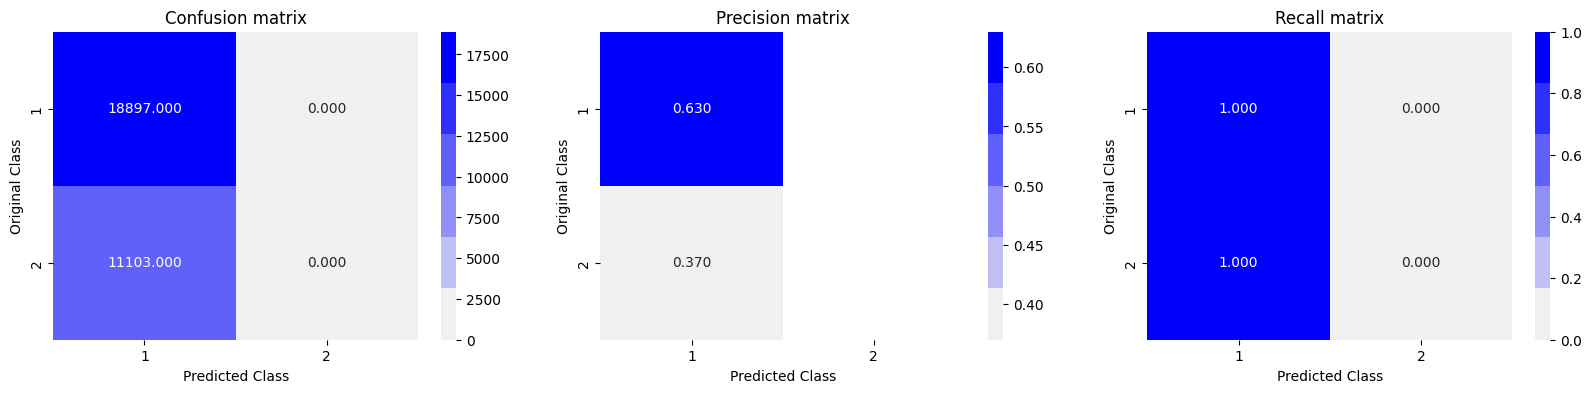

In [17]:
alpha = [10 ** x for x in range(-5, 2)]
param_grid = {'alpha': alpha}
base_clf = SGDClassifier(penalty='l1', loss='hinge', random_state=42)
grid = GridSearchCV(base_clf, param_grid, scoring='neg_log_loss', cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best alpha from GridSearchCV:", grid.best_params_['alpha'])
print("Best (negative) log loss:", grid.best_score_)

# Train and calibrate final model with best alpha
best_alpha = grid.best_params_['alpha']
clf = SGDClassifier(alpha=best_alpha, penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

# Evaluate
predict_y_train = sig_clf.predict_proba(X_train)
print('Train log loss:', log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15))
predict_y_test = sig_clf.predict_proba(X_test)
print('Test log loss:', log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-15))

train_predicted_y_class = np.argmax(predict_y_train, axis=1)
train_accuracy = accuracy_score(y_train, train_predicted_y_class)
print("Train accuracy:", train_accuracy)

test_predicted_y_class = np.argmax(predict_y_test, axis=1)
test_accuracy = accuracy_score(y_test, test_predicted_y_class)
print("Test accuracy:", test_accuracy)

plot_confusion_matrix(y_test, test_predicted_y_class)

c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-logloss:0.65152	valid-logloss:0.65152
[10]	train-logloss:0.58887	valid-logloss:0.58894
[20]	train-logloss:0.54339	valid-logloss:0.54359
[30]	train-logloss:0.50904	valid-logloss:0.50931
[40]	train-logloss:0.48309	valid-logloss:0.48342
[50]	train-logloss:0.46276	valid-logloss:0.46314
[60]	train-logloss:0.44636	valid-logloss:0.44691
[70]	train-logloss:0.43318	valid-logloss:0.43384
[80]	train-logloss:0.42245	valid-logloss:0.42317
[90]	train-logloss:0.41362	valid-logloss:0.41449
[100]	train-logloss:0.40620	valid-logloss:0.40720
[110]	train-logloss:0.40010	valid-logloss:0.40127
[120]	train-logloss:0.39486	valid-logloss:0.39620
[130]	train-logloss:0.39043	valid-logloss:0.39202
[140]	train-logloss:0.38658	valid-logloss:0.38844
[150]	train-logloss:0.38312	valid-logloss:0.38523
[160]	train-logloss:0.38016	valid-logloss:0.38256
[170]	train-logloss:0.37731	valid-logloss:0.38008
[180]	train-logloss:0.37486	valid-logloss:0.37792
[190]	train-logloss:0.37256	valid-logloss:0.37595
[200]	train

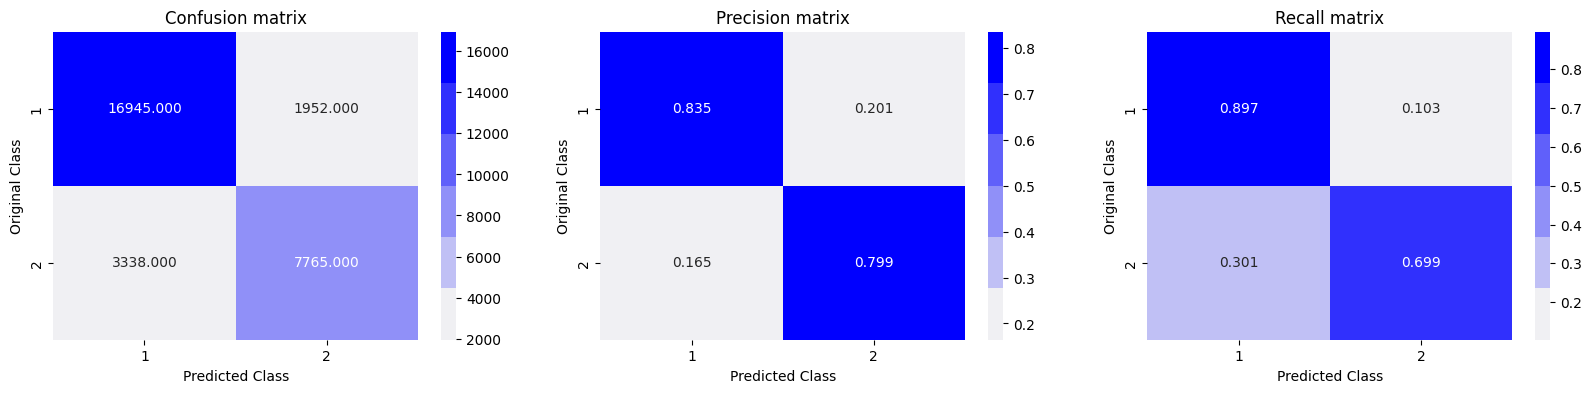

In [20]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

predict_y = bst.predict(d_test)
print("The test log loss is:", log_loss(y_test, predict_y))

predicted_y = np.array(predict_y > 0.5, dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)